In [1]:
from torch import nn
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.categorical import Categorical

In [2]:
import matplotlib.pyplot as plt

In [3]:
from Experiments.foong import Setup
device='cpu'
layerwidth=50
nblayers=1
setup=Setup(device,layerwidth=layerwidth,nblayers=nblayers)
param_count=setup.param_count
logposterior=setup.logposterior

In [4]:
logtarget = logposterior

In [47]:
nb_chain = 200
nb_iter = 1000
nb_inner = 5

temperature = torch.linspace(torch.tensor(1.0).log(), torch.tensor(10000000.0).log(), nb_chain).exp()

state = torch.rand((nb_chain,param_count))*0.00000001
acceptance = torch.zeros(nb_chain)
swapCount = torch.zeros((nb_chain,))
history = torch.zeros((nb_iter, nb_chain, param_count))
history[0] = state

In [48]:
for t in range(1, nb_iter):
    perturbation = MultivariateNormal(torch.zeros(param_count), torch.eye(param_count)*0.0001)
    candidate = state + perturbation.sample((nb_chain,))
    logratio = logtarget(candidate)/temperature - logtarget(state)/temperature
    accept = torch.rand((nb_chain,)).log() < logratio
    state[accept,:] = candidate[accept,:]
    history[t] = state
    acceptance += accept*1.0

    # SWAP PHASE
    if t % nb_inner == 0:
        logProba = logtarget(state)
        for j in np.random.permutation(nb_chain-1):
            T_left = temperature[j]
            T_right = temperature[j+1]
            LP_left = logProba[j]
            LP_right = logProba[j+1]

            logA = LP_left/T_right + LP_right/T_left \
                 - LP_left/T_left - LP_right/T_right

            R = torch.exp(logA).cpu()

            if torch.rand(1)[0] < R:
                tmp = state[j,:].detach().clone() 
                state[j,:] = state[j+1,:].detach().clone() 
                state[j+1,:] = tmp

                tmp = logProba[j].detach().clone() 
                logProba[j] = logProba[j+1].detach().clone() 
                logProba[j+1] = tmp

                swapCount[j] += 1

In [49]:
acceptance/nb_iter

tensor([0.1266, 0.1325, 0.1397, 0.1410, 0.1457, 0.1607, 0.1672, 0.1744, 0.1762,
        0.1962, 0.1987, 0.2071, 0.2137, 0.2192, 0.2287, 0.2407, 0.2505, 0.2576,
        0.2706, 0.2723, 0.2874, 0.3004, 0.3063, 0.3198, 0.3258, 0.3516, 0.3624,
        0.3765, 0.3839, 0.3982, 0.4205, 0.4302, 0.4363, 0.4553, 0.4668, 0.4813,
        0.4954, 0.5037, 0.5187, 0.5332, 0.5427, 0.5567, 0.5640, 0.5771, 0.5972,
        0.6118, 0.6185, 0.6384, 0.6380, 0.6549, 0.6646, 0.6714, 0.6821, 0.7013,
        0.7080, 0.7165, 0.7242, 0.7363, 0.7448, 0.7535, 0.7708, 0.7724, 0.7737,
        0.7936, 0.8072, 0.8073, 0.8117, 0.8163, 0.8285, 0.8362, 0.8441, 0.8545,
        0.8490, 0.8546, 0.8568, 0.8665, 0.8813, 0.8733, 0.8862, 0.8861, 0.8911,
        0.8927, 0.9000, 0.9030, 0.9058, 0.9096, 0.9092, 0.9158, 0.9177, 0.9218,
        0.9249, 0.9273, 0.9330, 0.9316, 0.9355, 0.9373, 0.9413, 0.9452, 0.9475,
        0.9488, 0.9519, 0.9514, 0.9550, 0.9557, 0.9569, 0.9632, 0.9641, 0.9608,
        0.9651, 0.9697, 0.9717, 0.9717, 

In [54]:
x_lin = torch.linspace(-2.0, 2.0).unsqueeze(1)

In [61]:
y_ = setup._model(x_lin, history[8000::,50,:]).detach().clone().cpu().numpy()

In [62]:
y_ = y_[:,:,0].transpose()

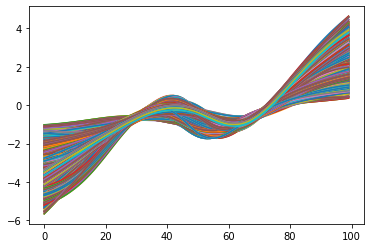

In [63]:
plt.plot(y_)
plt.show()